# Deep Learning na Previsão de Carga Elétrica com LSTM
 
 Este notebook implementa um modelo de Deep Learning utilizando LSTM (Long Short-Term Memory) para prever a carga elétrica no Subsistema Nordeste com base em dados históricos.

## 1. Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Métricas
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')

# Configurar GPU se disponível
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponível: {tf.config.list_physical_devices('GPU')}")
print("\n✓ Bibliotecas importadas com sucesso!")

TensorFlow version: 2.20.0
GPU disponível: []

✓ Bibliotecas importadas com sucesso!


## 2. Carregamento dos Dados

In [2]:
# Carregar dados processados do notebook 1-ETL_EDA
df = pd.read_csv('./db/dataset.csv', sep=';')
df['din_referencia'] = pd.to_datetime(df['din_referencia'])

print("=" * 80)
print("DADOS CARREGADOS")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"\nPeríodo: {df['din_referencia'].min()} a {df['din_referencia'].max()}")
print(f"\nColunas disponíveis:")
print(df.columns.tolist())

display(df.head())

DADOS CARREGADOS
Shape: (67871, 14)

Período: 2022-01-01 00:30:00 a 2025-11-14 23:30:00

Colunas disponíveis:
['din_referencia', 'ano', 'mes', 'dia', 'hora', 'dia_semana', 'trimestre', 'val_cargaglobal', 'val_cargaglobalcons', 'val_cargaglobalsmmgd', 'val_cargasupervisionada', 'val_carganaosupervisionada', 'val_cargammgd', 'val_consistencia']


,din_referencia,ano,mes,dia,hora,dia_semana,trimestre,val_cargaglobal,val_cargaglobalcons,val_cargaglobalsmmgd,val_cargasupervisionada,val_carganaosupervisionada,val_cargammgd,val_consistencia
0,2022-01-01 00:30:00,2022,1,1,0,5,1,10208.676,10208.676,10208.676,9322.776,885.8999,0.0,0.0
1,2022-01-01 01:00:00,2022,1,1,1,5,1,10259.559,10259.559,10259.559,9384.880,874.6782,0.0,0.0
2,2022-01-01 01:30:00,2022,1,1,1,5,1,10298.718,10298.718,10298.718,9427.878,870.8401,0.0,0.0
3,2022-01-01 02:00:00,2022,1,1,2,5,1,10368.665,10368.665,10368.665,9506.330,862.3351,0.0,0.0
4,2022-01-01 02:30:00,2022,1,1,2,5,1,10366.999,10366.999,10366.999,9505.038,861.9605,0.0,0.0


## 3. Preparação dos Dados para LSTM

### 3.1 Seleção e Ordenação dos Dados

In [3]:
# Ordenar por data e selecionar coluna target
df_lstm = df[['din_referencia', 'val_cargaglobal']].copy()
df_lstm = df_lstm.sort_values('din_referencia').reset_index(drop=True)

# Remover valores nulos
df_lstm = df_lstm.dropna()

print("=" * 80)
print("PREPARAÇÃO DOS DADOS - LSTM")
print("=" * 80)
print(f"Total de registros: {len(df_lstm)}")
print(f"Período: {df_lstm['din_referencia'].min()} a {df_lstm['din_referencia'].max()}")
print(f"\nEstatísticas da carga global:")
display(df_lstm['val_cargaglobal'].describe())

PREPARAÇÃO DOS DADOS - LSTM
Total de registros: 67871
Período: 2022-01-01 00:30:00 a 2025-11-14 23:30:00

Estatísticas da carga global:


count    67871.000000
mean     12605.225735
std       1405.210894
min       7096.327600
25%      11635.490500
50%      12609.516000
75%      13631.455000
max      20473.545000
Name: val_cargaglobal, dtype: float64

### 3.2 Normalização dos Dados

In [4]:
# Normalizar dados para escala [0, 1] (importante para LSTM)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_lstm[['val_cargaglobal']])

print("=" * 80)
print("NORMALIZAÇÃO DOS DADOS")
print("=" * 80)
print(f"Min original: {df_lstm['val_cargaglobal'].min():.2f} MW")
print(f"Max original: {df_lstm['val_cargaglobal'].max():.2f} MW")
print(f"\nMin normalizado: {data_scaled.min():.4f}")
print(f"Max normalizado: {data_scaled.max():.4f}")
print("\n✓ Dados normalizados com sucesso!")

NORMALIZAÇÃO DOS DADOS
Min original: 7096.33 MW
Max original: 20473.54 MW

Min normalizado: 0.0000
Max normalizado: 1.0000

✓ Dados normalizados com sucesso!


### 3.3 Criação de Sequências (Janelas Temporais)

In [5]:
def create_sequences(data, seq_length):
    """
    Cria sequências de dados para treinamento do LSTM
    
    Args:
        data (np.array): Dados normalizados
        seq_length (int): Comprimento da sequência (janela temporal)
    
    Returns:
        X (np.array): Sequências de entrada
        y (np.array): Valores target
    """
    X, y = [], []
    
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    
    return np.array(X), np.array(y)

# Definir comprimento da sequência (24h = 1 dia, 168h = 1 semana)
SEQ_LENGTH = 168  # Usar última semana para prever próxima hora

X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Reshape para formato LSTM [amostras, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

print("=" * 80)
print("CRIAÇÃO DE SEQUÊNCIAS")
print("=" * 80)
print(f"Comprimento da sequência: {SEQ_LENGTH} horas (1 semana)")
print(f"\nShape de X (entrada): {X.shape}")
print(f"  - Amostras: {X.shape[0]}")
print(f"  - Timesteps: {X.shape[1]}")
print(f"  - Features: {X.shape[2]}")
print(f"\nShape de y (target): {y.shape}")
print("\n✓ Sequências criadas com sucesso!")

CRIAÇÃO DE SEQUÊNCIAS
Comprimento da sequência: 168 horas (1 semana)

Shape de X (entrada): (67703, 168, 1)
  - Amostras: 67703
  - Timesteps: 168
  - Features: 1

Shape de y (target): (67703,)

✓ Sequências criadas com sucesso!


### 3.4 Divisão em Treino, Validação e Teste

In [6]:
# Divisão temporal (importante para séries temporais)
# 70% treino, 15% validação, 15% teste
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# Obter datas correspondentes
train_dates = df_lstm['din_referencia'].iloc[SEQ_LENGTH:SEQ_LENGTH+train_size]
val_dates = df_lstm['din_referencia'].iloc[SEQ_LENGTH+train_size:SEQ_LENGTH+train_size+val_size]
test_dates = df_lstm['din_referencia'].iloc[SEQ_LENGTH+train_size+val_size:]

print("=" * 80)
print("DIVISÃO DOS DADOS")
print("=" * 80)
print(f"Total de amostras: {len(X)}\n")

print(f"Treino: {len(X_train)} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Período: {train_dates.min()} a {train_dates.max()}")

print(f"\nValidação: {len(X_val)} amostras ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Período: {val_dates.min()} a {val_dates.max()}")

print(f"\nTeste: {len(X_test)} amostras ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Período: {test_dates.min()} a {test_dates.max()}")

DIVISÃO DOS DADOS
Total de amostras: 67703

Treino: 47392 amostras (70.0%)
  Período: 2022-01-04 12:30:00 a 2024-09-17 20:00:00

Validação: 10155 amostras (15.0%)
  Período: 2024-09-17 20:30:00 a 2025-04-17 09:30:00

Teste: 10156 amostras (15.0%)
  Período: 2025-04-17 10:00:00 a 2025-11-14 23:30:00


## 4. Construção do Modelo LSTM

### 4.1 Arquitetura do Modelo

In [7]:
# Limpar sessão anterior do Keras
keras.backend.clear_session()

# Construir modelo LSTM
model = Sequential([
    # Primeira camada LSTM bidirecional
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, 1))),
    Dropout(0.2),
    
    # Segunda camada LSTM
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    
    # Terceira camada LSTM
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    
    # Camadas Dense
    Dense(16, activation='relu'),
    Dense(1)
])

# Compilar modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Construir o modelo com a forma de entrada
model.build(input_shape=(None, SEQ_LENGTH, 1))

print("=" * 80)
print("ARQUITETURA DO MODELO LSTM")
print("=" * 80)
model.summary()

print(f"\nTotal de parâmetros: {model.count_params():,}")


ARQUITETURA DO MODELO LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 168, 256)       │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 168, 64)        │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,257 (891.63 KB)

 Trainable params: 228,257 (891.63 KB)

 Non-trainable params: 0 (0.00 B)


Total de parâmetros: 228,257


### 4.2 Callbacks para Treinamento

In [8]:
# Definir callbacks
callbacks = [
    # Early Stopping: parar se validação não melhorar
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Model Checkpoint: salvar melhor modelo
    ModelCheckpoint(
        'best_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce Learning Rate: reduzir LR se não melhorar
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

print("✓ Callbacks configurados:")
print("  - Early Stopping (patience=15)")
print("  - Model Checkpoint")
print("  - Reduce Learning Rate on Plateau")

✓ Callbacks configurados:
  - Early Stopping (patience=15)
  - Model Checkpoint
  - Reduce Learning Rate on Plateau


### 4.3 Treinamento do Modelo

In [9]:
# Treinar modelo
print("=" * 80)
print("INICIANDO TREINAMENTO")
print("=" * 80)

EPOCHS = 30
BATCH_SIZE = 64

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 80)
print("✓ TREINAMENTO CONCLUÍDO!")
print("=" * 80)

INICIANDO TREINAMENTO
Epoch 1/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 0.0063 - mae: 0.0543
Epoch 1: val_loss improved from None to 0.00134, saving model to best_lstm_model.keras
741/741 ━━━━━━━━━━━━━━━━━━━━ 282s 375ms/step - loss: 0.0026 - mae: 0.0363 - val_loss: 0.0013 - val_mae: 0.0293 - learning_rate: 0.0010
Epoch 2/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 7.5314e-04 - mae: 0.0210
Epoch 2: val_loss improved from 0.00134 to 0.00047, saving model to best_lstm_model.keras
741/741 ━━━━━━━━━━━━━━━━━━━━ 201s 272ms/step - loss: 6.9183e-04 - mae: 0.0200 - val_loss: 4.7369e-04 - val_mae: 0.0169 - learning_rate: 0.0010
Epoch 3/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 5.4704e-04 - mae: 0.0178
Epoch 3: val_loss improved from 0.00047 to 0.00041, saving model to best_lstm_model.keras
741/741 ━━━━━━━━━━━━━━━━━━━━ 184s 248ms/step - loss: 5.5186e-04 - mae: 0.0177 - val_loss: 4.0816e-04 - val_mae: 0.0157 - learning_rate: 0.0010
Epoch 4/30
741/741 ━━━━━━━━━━━━━━

### 4.4 Histórico de Treinamento

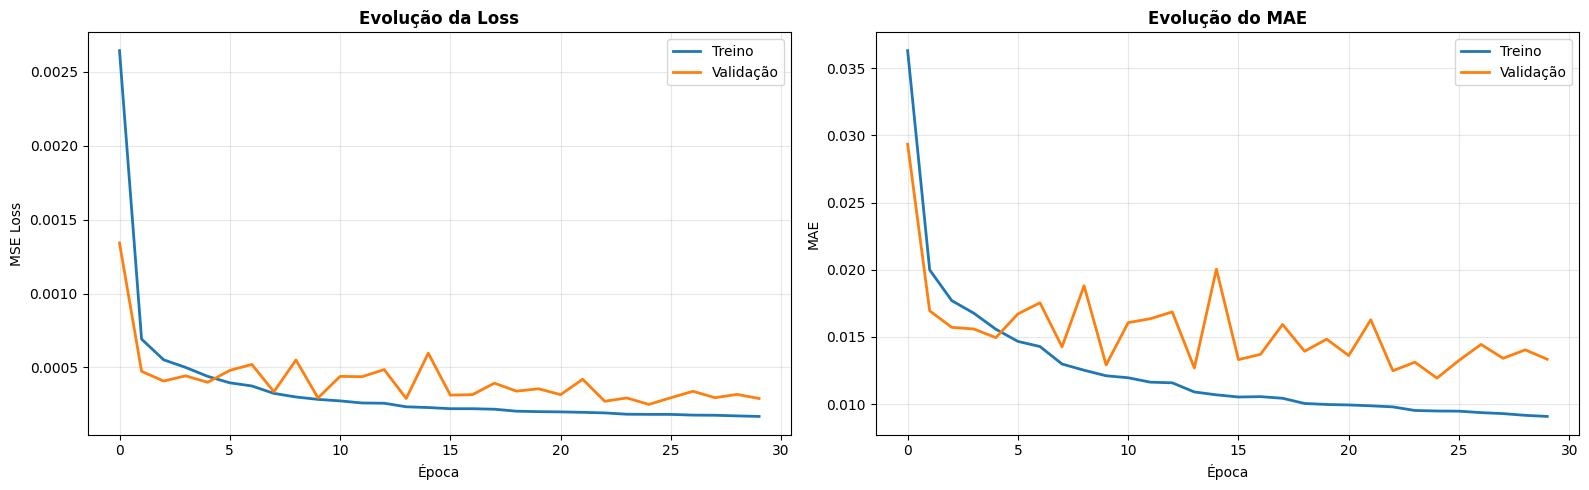


Número de épocas treinadas: 30
Melhor val_loss: 0.000250
Melhor val_mae: 0.011930


In [10]:
# Visualizar histórico de treinamento
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(history.history['loss'], label='Treino', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validação', linewidth=2)
axes[0].set_title('Evolução da Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Época', fontsize=10)
axes[0].set_ylabel('MSE Loss', fontsize=10)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Treino', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validação', linewidth=2)
axes[1].set_title('Evolução do MAE', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Época', fontsize=10)
axes[1].set_ylabel('MAE', fontsize=10)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nNúmero de épocas treinadas: {len(history.history['loss'])}")
print(f"Melhor val_loss: {min(history.history['val_loss']):.6f}")
print(f"Melhor val_mae: {min(history.history['val_mae']):.6f}")

## 5. Avaliação do Modelo

### 5.1 Previsões nos Conjuntos de Dados

In [11]:
# Fazer previsões
y_train_pred = model.predict(X_train, verbose=0)
y_val_pred = model.predict(X_val, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

# Desnormalizar previsões e valores reais
y_train_real = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred = scaler.inverse_transform(y_train_pred)

y_val_real = scaler.inverse_transform(y_val.reshape(-1, 1))
y_val_pred = scaler.inverse_transform(y_val_pred)

y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_test_pred)

### 5.2 Métricas de Performance

In [12]:
def calculate_metrics(y_true, y_pred, dataset_name):
    """Calcula métricas de performance"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{dataset_name}:")
    print(f"  RMSE: {rmse:.2f} MW")
    print(f"  MAE:  {mae:.2f} MW")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

print("=" * 80)
print("MÉTRICAS DE AVALIAÇÃO - LSTM")
print("=" * 80)

metrics_train = calculate_metrics(y_train_real, y_train_pred, "Conjunto de Treino")
metrics_val = calculate_metrics(y_val_real, y_val_pred, "Conjunto de Validação")
metrics_test = calculate_metrics(y_test_real, y_test_pred, "Conjunto de Teste")

# Criar DataFrame com métricas
metrics_df = pd.DataFrame({
    'Conjunto': ['Treino', 'Validação', 'Teste'],
    'RMSE (MW)': [metrics_train['rmse'], metrics_val['rmse'], metrics_test['rmse']],
    'MAE (MW)': [metrics_train['mae'], metrics_val['mae'], metrics_test['mae']],
    'R²': [metrics_train['r2'], metrics_val['r2'], metrics_test['r2']],
    'MAPE (%)': [metrics_train['mape'], metrics_val['mape'], metrics_test['mape']]
})

print("\n" + "=" * 80)
print("RESUMO DAS MÉTRICAS")
print("=" * 80)
display(metrics_df)

MÉTRICAS DE AVALIAÇÃO - LSTM

Conjunto de Treino:
  RMSE: 246.45 MW
  MAE:  181.88 MW
  R²:   0.9637
  MAPE: 1.59%

Conjunto de Validação:
  RMSE: 211.45 MW
  MAE:  159.59 MW
  R²:   0.9673
  MAPE: 1.16%

Conjunto de Teste:
  RMSE: 222.87 MW
  MAE:  160.25 MW
  R²:   0.9683
  MAPE: 1.22%

RESUMO DAS MÉTRICAS


,Conjunto,RMSE (MW),MAE (MW),R²,MAPE (%)
0,Treino,246.447327,181.882422,0.963651,1.589139
1,Validação,211.445406,159.586548,0.967285,1.160290
2,Teste,222.866718,160.248668,0.968346,1.220347


### 5.3 Visualizações de Performance

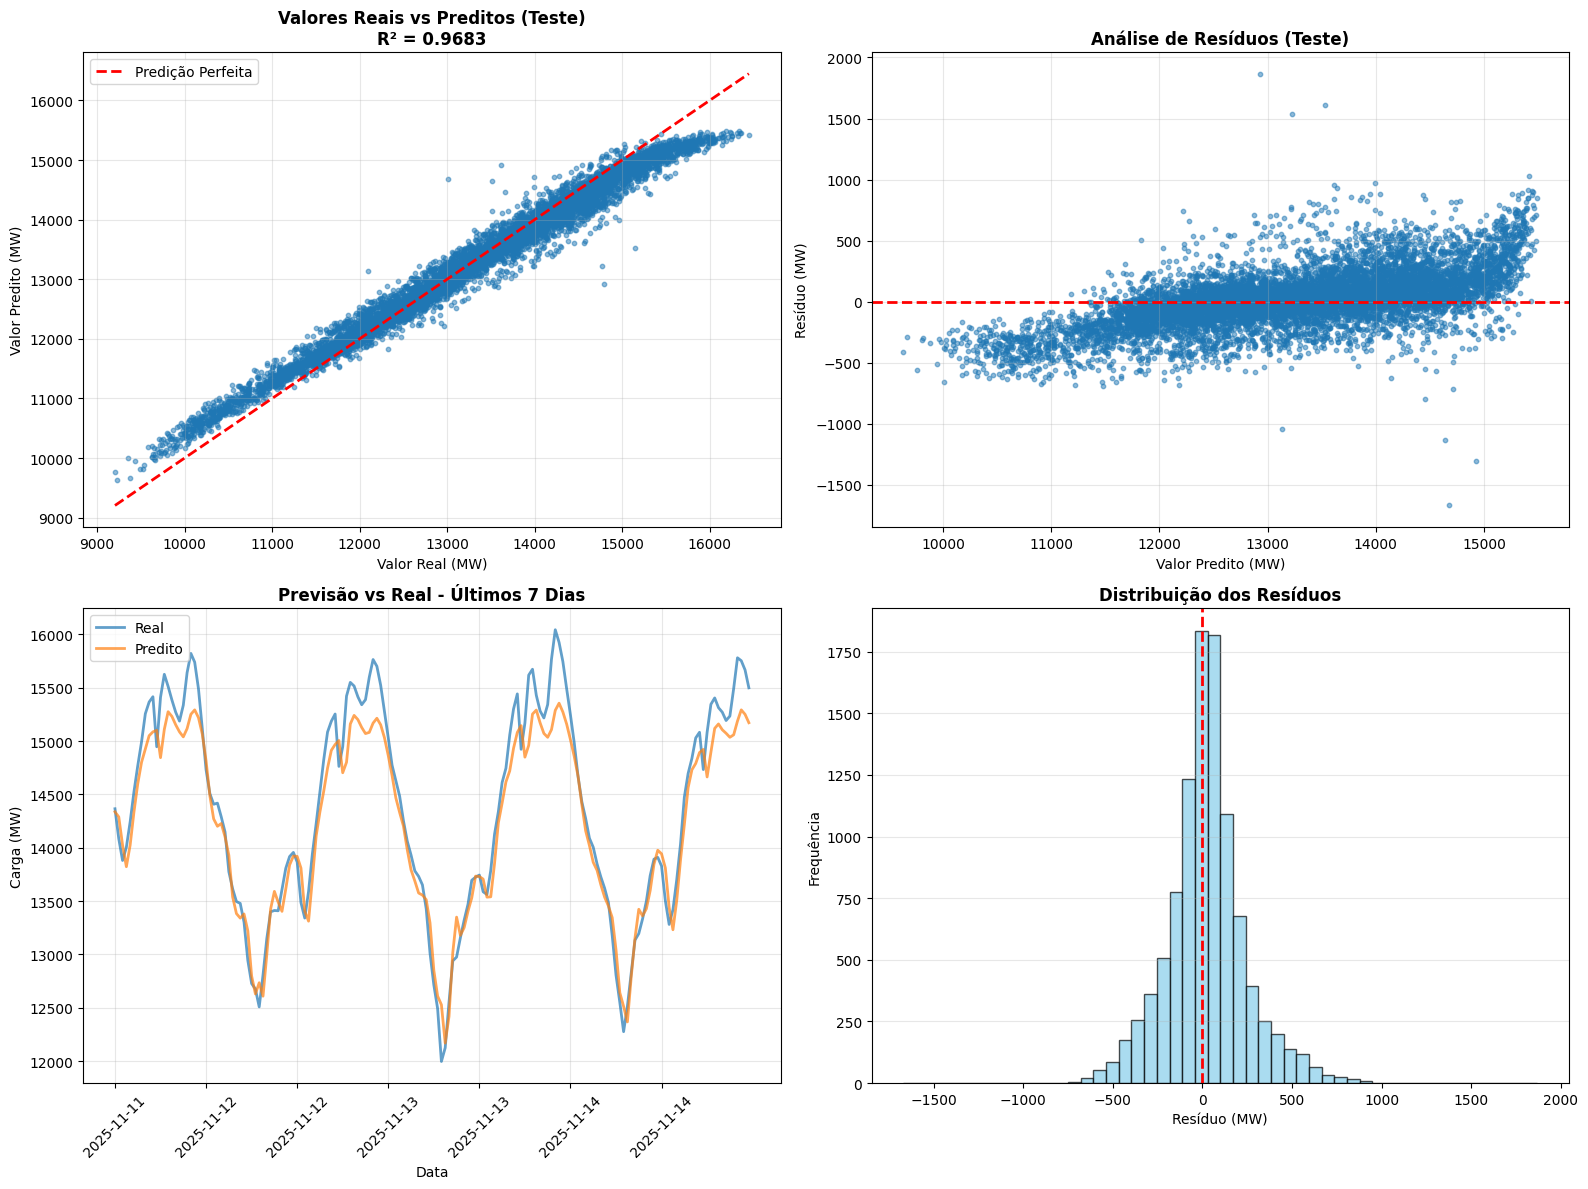

In [13]:
# Visualizações de performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Valores reais vs preditos (teste)
axes[0, 0].scatter(y_test_real, y_test_pred, alpha=0.5, s=10)
axes[0, 0].plot([y_test_real.min(), y_test_real.max()], 
               [y_test_real.min(), y_test_real.max()], 
               'r--', linewidth=2, label='Predição Perfeita')
axes[0, 0].set_xlabel('Valor Real (MW)', fontsize=10)
axes[0, 0].set_ylabel('Valor Predito (MW)', fontsize=10)
axes[0, 0].set_title(f'Valores Reais vs Preditos (Teste)\nR² = {metrics_test["r2"]:.4f}', 
                    fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Resíduos
residuos = y_test_real.flatten() - y_test_pred.flatten()
axes[0, 1].scatter(y_test_pred, residuos, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Valor Predito (MW)', fontsize=10)
axes[0, 1].set_ylabel('Resíduo (MW)', fontsize=10)
axes[0, 1].set_title('Análise de Resíduos (Teste)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Série temporal - últimos 7 dias do teste
last_week_idx = -168  # últimos 7 dias (24h * 7)
test_dates_array = test_dates.values

axes[1, 0].plot(test_dates_array[last_week_idx:], 
               y_test_real[last_week_idx:], 
               label='Real', linewidth=2, alpha=0.7)
axes[1, 0].plot(test_dates_array[last_week_idx:], 
               y_test_pred[last_week_idx:], 
               label='Predito', linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('Data', fontsize=10)
axes[1, 0].set_ylabel('Carga (MW)', fontsize=10)
axes[1, 0].set_title('Previsão vs Real - Últimos 7 Dias', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Configurar ticks a cada 24 horas (1 dia)
dates_to_show = test_dates_array[last_week_idx::24]
axes[1, 0].set_xticks(dates_to_show)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Distribuição dos erros
axes[1, 1].hist(residuos, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Resíduo (MW)', fontsize=10)
axes[1, 1].set_ylabel('Frequência', fontsize=10)
axes[1, 1].set_title('Distribuição dos Resíduos', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 5.4 Comparação Temporal

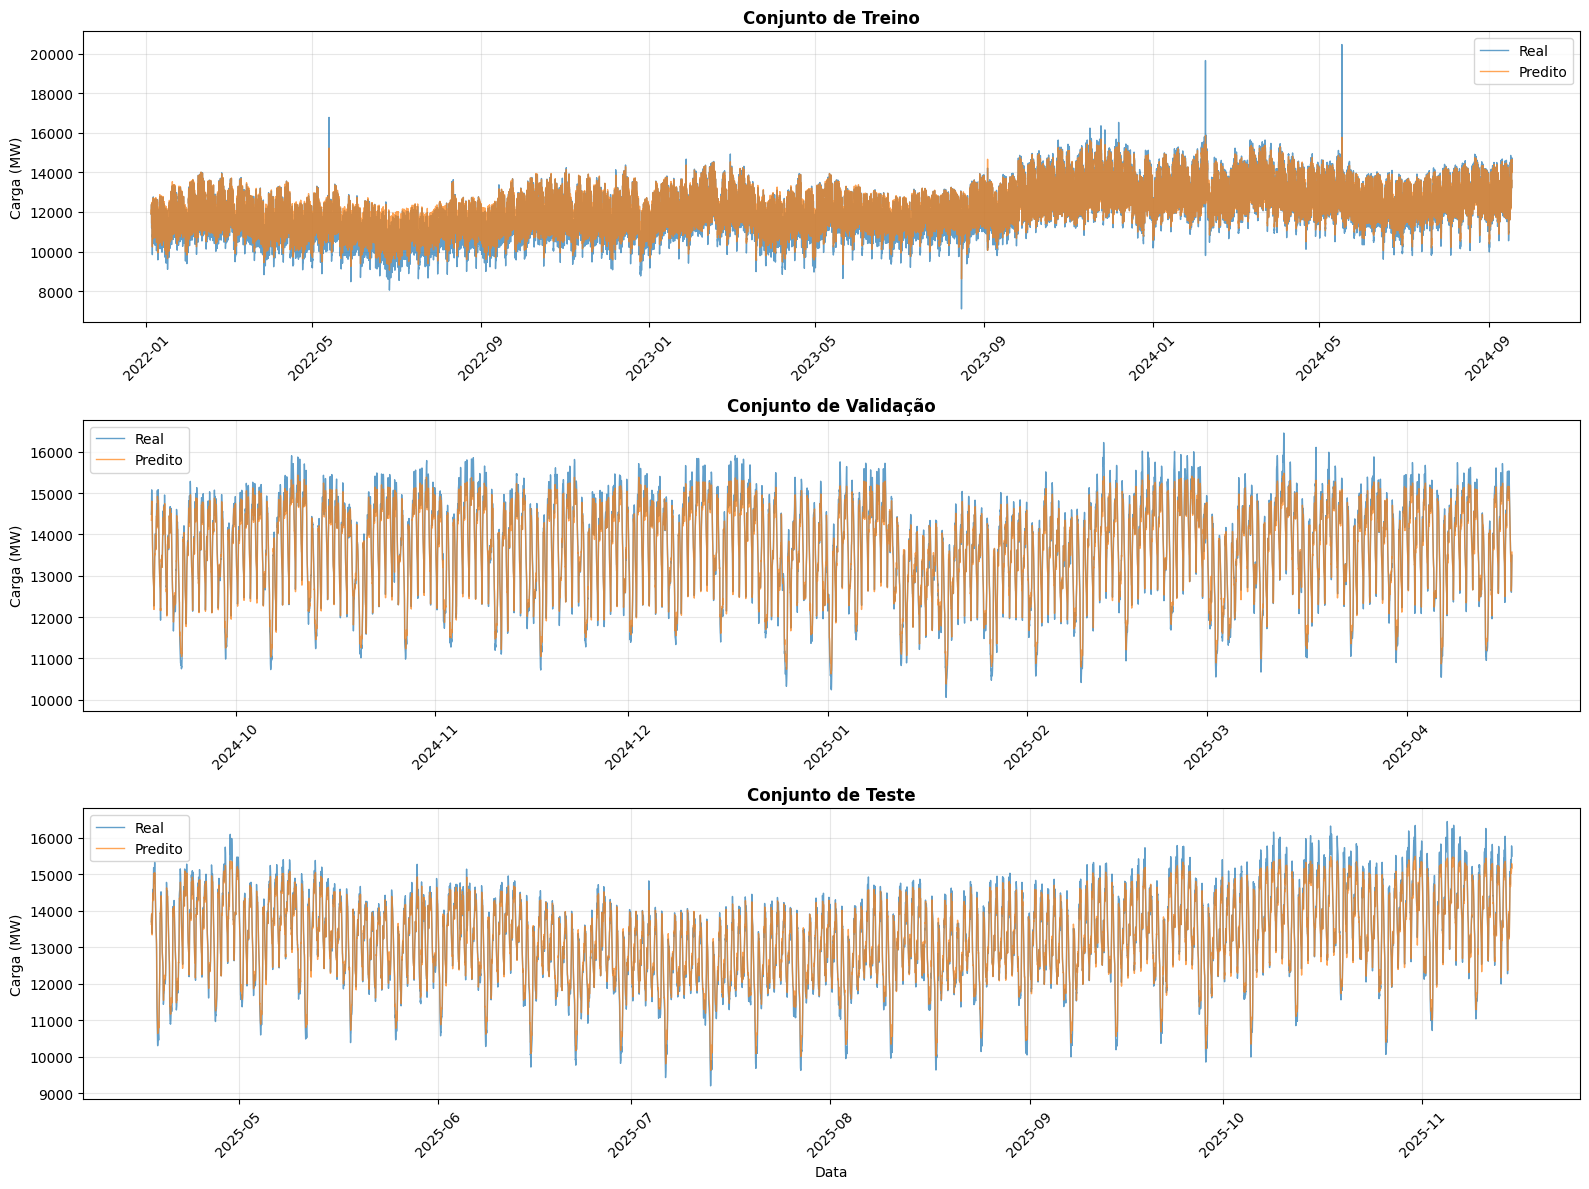

In [14]:
# Visualização completa da série temporal
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Treino
axes[0].plot(train_dates, y_train_real, label='Real', linewidth=1, alpha=0.7)
axes[0].plot(train_dates, y_train_pred, label='Predito', linewidth=1, alpha=0.7)
axes[0].set_title('Conjunto de Treino', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Carga (MW)', fontsize=10)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validação
axes[1].plot(val_dates, y_val_real, label='Real', linewidth=1, alpha=0.7)
axes[1].plot(val_dates, y_val_pred, label='Predito', linewidth=1, alpha=0.7)
axes[1].set_title('Conjunto de Validação', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Carga (MW)', fontsize=10)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Teste
axes[2].plot(test_dates, y_test_real, label='Real', linewidth=1, alpha=0.7)
axes[2].plot(test_dates, y_test_pred, label='Predito', linewidth=1, alpha=0.7)
axes[2].set_title('Conjunto de Teste', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Data', fontsize=10)
axes[2].set_ylabel('Carga (MW)', fontsize=10)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Comparação com Baseline

In [17]:
# Criar baseline simples: persistência (valor anterior)
y_test_baseline = y_test_real[:-1]  # Usar valor anterior como previsão
y_test_real_baseline = y_test_real[1:]  # Valores reais correspondentes

# Métricas do baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test_real_baseline, y_test_baseline))
baseline_mae = mean_absolute_error(y_test_real_baseline, y_test_baseline)
baseline_r2 = r2_score(y_test_real_baseline, y_test_baseline)
baseline_mape = np.mean(np.abs((y_test_real_baseline - y_test_baseline) / y_test_real_baseline)) * 100

print("=" * 80)
print("COMPARAÇÃO: LSTM vs BASELINE (Persistência)")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Modelo': ['LSTM', 'Baseline'],
    'RMSE (MW)': [metrics_test['rmse'], baseline_rmse],
    'MAE (MW)': [metrics_test['mae'], baseline_mae],
    'R²': [metrics_test['r2'], baseline_r2],
    'MAPE (%)': [metrics_test['mape'], baseline_mape]
})

display(comparison_df)

# Calcular melhorias
print("\n" + "=" * 80)
print("MELHORIA DO LSTM EM RELAÇÃO AO BASELINE")
print("=" * 80)
print(f"RMSE: {((baseline_rmse - metrics_test['rmse']) / baseline_rmse * 100):.2f}% melhor")
print(f"MAE:  {((baseline_mae - metrics_test['mae']) / baseline_mae * 100):.2f}% melhor")
print(f"MAPE: {((baseline_mape - metrics_test['mape']) / baseline_mape * 100):.2f}% melhor")

COMPARAÇÃO: LSTM vs BASELINE (Persistência)


,Modelo,RMSE (MW),MAE (MW),R²,MAPE (%)
0,LSTM,222.866718,160.248668,0.968346,1.220347
1,Baseline,220.593753,169.833394,0.968991,1.280301



MELHORIA DO LSTM EM RELAÇÃO AO BASELINE
RMSE: -1.03% melhor
MAE:  5.64% melhor
MAPE: 4.68% melhor
